In [3]:
!pip install ibmos2spark

  Using cached https://files.pythonhosted.org/packages/c6/81/1edb24382edef1ca636e87972b2da286b8271a586c728a21f916d3cd76cd/ibmos2spark-1.0.1-py2.py3-none-any.whl
Target directory /home/spark/shared/user-libs/python3/ibmos2spark-1.0.1.dist-info already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3/ibmos2spark already exists. Specify --upgrade to force replacement.


In [4]:
# Configuration
# Each country has a tsv file with dates and exchange rates against
# the U.S. dollar

countries = ['Australia', 'Brazil', 'Canada', 'China', 
         'Denmark', 'EU', 'Hong_Kong', 'India', 
         'Japan', 'Malaysia', 'New_Zealand', 'Norway',
         'Singapore', 'South_Africa', 'South_Korea',
         'Sri_Lanka', 'Sweden', 'Switzerland', 'Taiwan',
         'Thailand', 'United_Kingdom','Venezuela']

this_stage = "feature_eng"
previous_stage = "etl"

In [5]:
import ibmos2spark
from pyspark.sql.types import *

# Configuration
# Prepare to access IBM Object Storage

# @hidden_cell
credentials = {
    'service_id': 'iam-ServiceId-e4b1b62b-e030-4b68-a71f-a12e44f23c33',
    'api_key': '9-RaWWhWwA-jm5BkfQ1pxtj-J5xvpjYKMrSgMk9vQxX1',
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'bucket': 'forex-donotdelete-pr-ksiby6mz5os7oj'
}

# configuration_name = 'os_forex'
configuration_name = ''
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

print(type(cos))

bucket_name = 'forex-donotdelete-pr-ksiby6mz5os7oj'

<class 'ibmos2spark.osconfig.CloudObjectStorage'>


In [6]:
data_url = cos.url(previous_stage + ".parquet", bucket_name)
df = spark.read.format("parquet").load(data_url)
df = df.sort('Date', ascending=True)
df.show()

+----------+---------+------+------+------+-------+------+---------+-----+------+--------+-----------+------+---------+------------+-----------+---------+------+-----------+------+--------+--------------+---------+
|      Date|Australia|Brazil|Canada| China|Denmark|    EU|Hong_Kong|India| Japan|Malaysia|New_Zealand|Norway|Singapore|South_Africa|South_Korea|Sri_Lanka|Sweden|Switzerland|Taiwan|Thailand|United_Kingdom|Venezuela|
+----------+---------+------+------+------+-------+------+---------+-----+------+--------+-----------+------+---------+------------+-----------+---------+------+-----------+------+--------+--------------+---------+
|2018-02-27|   0.7804|3.2472|1.2748|6.3169| 6.0828|1.2239|   7.8267|64.84|107.47|   3.906|     0.7243|7.8669|   1.3222|     11.7075|    1077.43|    154.8|8.2235|     0.9398| 29.29|   31.47|        1.3906|  28927.5|
|2018-02-28|   0.7801|3.2428|1.2806| 6.328| 6.0973|1.2211|   7.8262| 65.2|106.62|   3.915|     0.7227|7.8798|   1.3231|       11.78|    1082

In [7]:
print("""
Guidelines for feature transformation:

· Imputing Some algorithms are very sensitive to missing values. Therefore, imputing allows for filling of empty fields based on its value distribution

· Imputed time-series quantization Time series often contain streams with measurements at different timestamps. Therefore, it is beneficial to quantize measurements to a common “heart beat” and impute the corresponding values. This can be done by sampling from the source time series distributions on the respective quantized time steps

· Scaling / Normalizing / Centering Some algorithms are very sensitive differences in value ranges for individual fields. Therefore, it is best practice to center data around zero and scale values to a standard deviation of one

· Filtering Sometimes imputing values doesn’t perform well, therefore deletion of low quality records is a better strategy

· Discretizing Continuous fields might confuse the model, e.g. a discrete set of age ranges sometimes performs better than continuous values, especially on smaller amounts of data and with simpler models

The following none exhaustive list gives you some guidelines for feature creation:

· One-hot-encoding Categorical integer features should be transformed into “one-hot” vectors. In relational terms this results in addition of additional columns – one columns for each distinct category

· Time-to-Frequency transformation Time-series (and sometimes also sequence data) is recorded in the time domain but can easily transformed into the frequency domain e.g. using FFT (Fast Fourier Transformation)

· Month-From-Date Creating an additional feature containing the month independent from data captures seasonal aspects. Sometimes further discretization in to quarters helps as well

· Aggregate-on-Target Simply aggregating fields the target variable (or even other fields) can improve performance, e.g. count number of data points per ZIP code or take the median of all values by geographical region

""")


Guidelines for feature transformation:

· Imputing Some algorithms are very sensitive to missing values. Therefore, imputing allows for filling of empty fields based on its value distribution

· Imputed time-series quantization Time series often contain streams with measurements at different timestamps. Therefore, it is beneficial to quantize measurements to a common “heart beat” and impute the corresponding values. This can be done by sampling from the source time series distributions on the respective quantized time steps

· Scaling / Normalizing / Centering Some algorithms are very sensitive differences in value ranges for individual fields. Therefore, it is best practice to center data around zero and scale values to a standard deviation of one

· Filtering Sometimes imputing values doesn’t perform well, therefore deletion of low quality records is a better strategy

· Discretizing Continuous fields might confuse the model, e.g. a discrete set of age ranges sometimes performs bett

In [8]:
series_len = df.count()
series_len

4911

In [22]:
# !pip install tensorflow==2.0.0b1


+----------+---------+------+------+------+-------+------+---------+-----+------+--------+-----------+------+---------+------------+-----------+---------+------+-----------+------+--------+--------------+---------+
|      Date|Australia|Brazil|Canada| China|Denmark|    EU|Hong_Kong|India| Japan|Malaysia|New_Zealand|Norway|Singapore|South_Africa|South_Korea|Sri_Lanka|Sweden|Switzerland|Taiwan|Thailand|United_Kingdom|Venezuela|
+----------+---------+------+------+------+-------+------+---------+-----+------+--------+-----------+------+---------+------------+-----------+---------+------+-----------+------+--------+--------------+---------+
|2000-01-04|   0.6562|1.8405|1.4518|8.2799|  7.218|1.0309|   7.7775|43.55|103.09|     3.8|     0.5198| 7.934|   1.6535|       6.085|     1122.5|    72.65|  8.36|     1.5565|  30.6|   37.13|         1.637|   0.6503|
|2000-01-05|    0.655| 1.856|1.4518|8.2798|  7.208|1.0335|    7.778|43.55|103.77|     3.8|     0.5171| 7.935|    1.656|        6.07|     113

In [10]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [81]:
import numpy as np

#########################################
# CURRENTLY CREATING A SINGLE SERIES
# NEED TO UTILIZE & SPLIT ALL 18 SERIES
#########################################

series = np.array(df.select('Australia').collect())
series = series.reshape(series.shape[0])
series.shape
split_time = series_len // 2
time = np.array(range(series_len))
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
x_valid

array([0.92040002, 0.91579998, 0.92659998, ..., 0.6742    , 0.67839998,
       0.67820001])

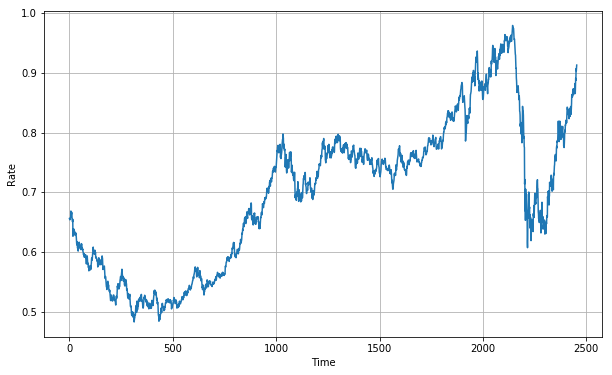

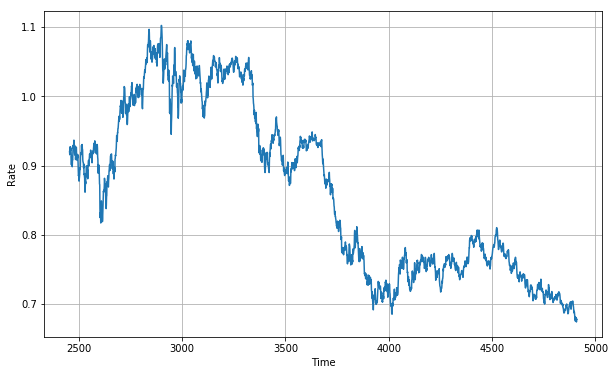

In [82]:
# The intention is to train a general purpose model initially,
# which can be used later using transfer learning to create 
# pairwise exchange rate predictors (e.g. for rates between two
# specific countries)
#
# Therefor, the data needs to be organized as 18 separate sequences.
# It would be beneficial to use a different 'split_time' to 
# separate each country's train / test split so as to train
# using a sample over the complete time interval, but we will 
# start by just splitting at the time midpoint.

import matplotlib.pyplot as plt
%matplotlib inline

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Rate")
    plt.grid(True)
    
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (2456,) and (2408,)

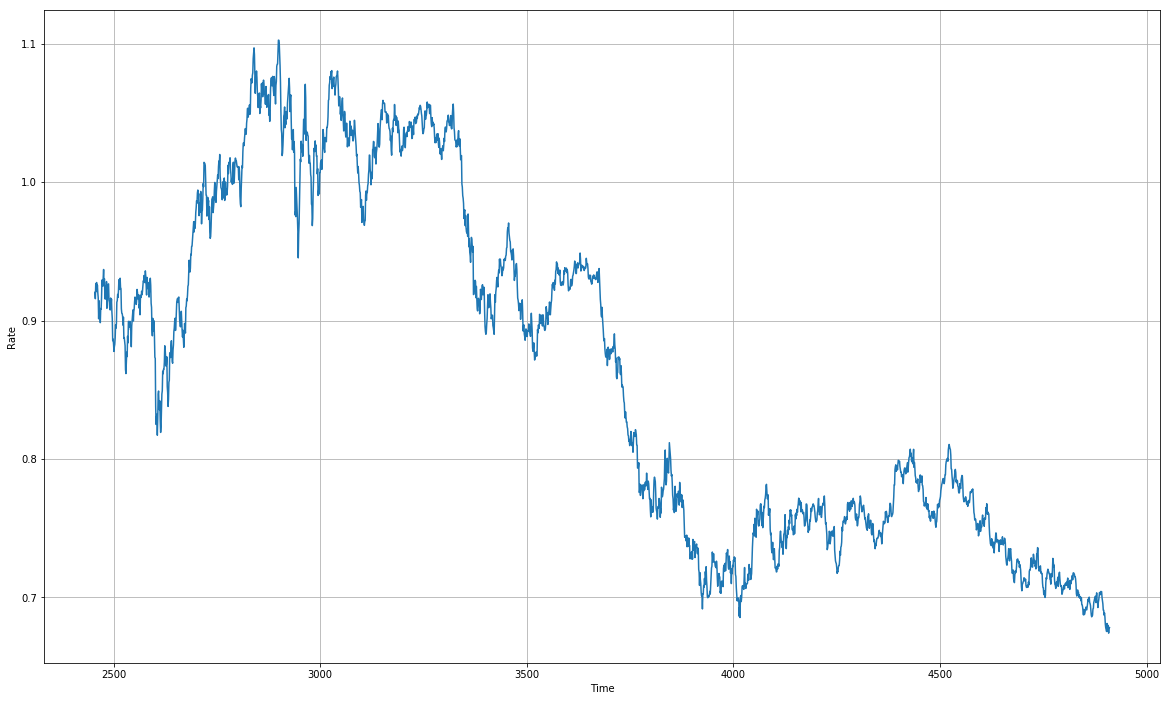

In [90]:
naive_forecast = series[split_time - 1:-1]
plt.figure(figsize=(20, 12))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)
plt.axis([3800, 4000, 0.65, 0.8])

In [103]:
# Creating some utility functions to:
# 1. create tf Dataset objects from numpy arrays
# 2. generate instances of windows given a size 'window_size'
#    which will become a training sequence instance
# 3. keeps batches of 'batch_size' together
# 4. randomizes sequences using 'shuffle' within the batches  

########################################################################
# windowed_dataset
# 
# series: 1D numpy array with rates
# window_size: integer defining the number of time-steps per sequence
# batch_size: integer defining number of instances per training epoch
# shuffle_buffer: size of buffer for randomizing data
#
# returns a tf.data.Dataset ready for LSTM model input
########################################################################
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # shuffles after correct training sequences exist
    ds = ds.shuffle(shuffle_buffer) 
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size, batch_size=32):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [107]:
window_size = 32
batch_size = 256
shuffle_buffer_size = 1000

def createEvenlyDivisible(series, batch_size):
    magic_len = series.shape[0] - (series.shape[0] % batch_size)
    return series[:magic_len-1]

series = createEvenlyDivisible(series, batch_size)

print(series.shape)
print(x_train.shape)
print(x_valid.shape)

(4351,)
(2455,)
(2456,)


In [108]:
tf.keras.backend.clear_session()

window_size = 32
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
for window_dataset in train_set:
  for win in window_dataset:
    print(win.numpy(), end=" ")


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
[[[0.52329999]
  [0.5273    ]
  [0.52509999]
  ...
  [0.51779997]
  [0.51099998]
  [0.50999999]]

 [[0.52530003]
  [0.52350003]
  [0.5212    ]
  ...
  [0.537     ]
  [0.53869998]
  [0.53899997]]

 [[0.50650001]
  [0.51419997]
  [0.5126    ]
  ...
  [0.52850002]
  [0.52920002]
  [0.52999997]]

 ...

 [[0.49399999]
  [0.4984    ]
  [0.49970001]
  ...
  [0.50650001]
  [0.51020002]
  [0.50959998]]

 [[0.51899999]
  [0.52170002]
  [0.52130002]
  ...
  [0.52380002]
  [0.5237    ]
  [0.52289999]]

 [[0.59960002]
  [0.60100001]
  [0.597     ]
  ...
  [0.64740002]
  [0.64249998]
  [0.65020001]]] [[[0.5273    ]
  [0.52509999]
  [0.52899998]
  ...
  [0.51099998]
  [0.50999999]
  [0.51059997]]

 [[0.52350003]
  [0.5212    ]
  [0.52060002]
  ...
  [0.53869998]
  [0.53899997]
  [0.53899997]]

 [[0.51419997]
  [0.5126    ]
  [0.50550002]
  ...
  [0.52920002]
  [0.52999997]
  [0.53299999]]

 ...

 [[0.4984   

  [0.51310003]]] [[[0.78930002]
  [0.79210001]
  [0.78179997]
  ...
  [0.77280003]
  [0.7737    ]
  [0.77649999]]

 [[0.95069999]
  [0.95730001]
  [0.954     ]
  ...
  [0.92989999]
  [0.91570002]
  [0.90780002]]

 [[0.93709999]
  [0.91839999]
  [0.9271    ]
  ...
  [0.93949997]
  [0.93300003]
  [0.93949997]]

 ...

 [[0.74879998]
  [0.74070001]
  [0.7428    ]
  ...
  [0.72839999]
  [0.73369998]
  [0.7238    ]]

 [[0.7428    ]
  [0.74839997]
  [0.75309998]
  ...
  [0.7238    ]
  [0.70310003]
  [0.69099998]]

 [[0.85369998]
  [0.85949999]
  [0.85729998]
  ...
  [0.84009999]
  [0.83950001]
  [0.84149998]]] [[[0.79210001]
  [0.78179997]
  [0.77740002]
  ...
  [0.7737    ]
  [0.77649999]
  [0.77579999]]

 [[0.95730001]
  [0.954     ]
  [0.95730001]
  ...
  [0.91570002]
  [0.90780002]
  [0.90789998]]

 [[0.91839999]
  [0.9271    ]
  [0.92140001]
  ...
  [0.93300003]
  [0.93949997]
  [0.93470001]]

 ...

 [[0.74070001]
  [0.7428    ]
  [0.74839997]
  ...
  [0.73369998]
  [0.7238    ]
  [0.703

In [87]:
a.shape

(223, 32, 1)

In [88]:
# ONLY RUN THIS CELL ONCE TO DETERMINE 'learning rate'

tf.keras.backend.clear_session()

# window_size = 32
# batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2455,)
Epoch 1/100
10/10 [==============================] - 5s 525ms/step - loss: 0.8532 - mae: 1.3160
Epoch 2/100
10/10 [==============================] - 2s 238ms/step - loss: 0.6516 - mae: 1.1050
Epoch 3/100
10/10 [==============================] - 2s 214ms/step - loss: 0.4058 - mae: 0.8171
Epoch 4/100
10/10 [==============================] - 2s 226ms/step - loss: 0.2290 - mae: 0.5661
Epoch 5/100
10/10 [==============================] - 2s 210ms/step - loss: 0.1525 - mae: 0.4385
Epoch 6/100
10/10 [==============================] - 2s 214ms/step - loss: 0.1370 - mae: 0.4134
Epoch 7/100
10/10 [==============================] - 2s 214ms/step - loss: 0.1373 - mae: 0.4179
Epoch 8/100
10/10 [==============================] - 2s 213ms/step - loss: 0.1360 - mae: 0.4172
Epoch 9/100
10/10 [==============================] - 2s 210ms/step - loss: 0.1327 - mae: 0.4115
Epoch 10/100
10/10 [==============

10/10 [==============================] - 2s 197ms/step - loss: 13.6302 - mae: 13.1680
Epoch 85/100
10/10 [==============================] - 2s 205ms/step - loss: 18.2786 - mae: 17.9188
Epoch 86/100
10/10 [==============================] - 2s 206ms/step - loss: 29.0022 - mae: 29.1294
Epoch 87/100
10/10 [==============================] - 2s 219ms/step - loss: 27.6206 - mae: 27.1221
Epoch 88/100
10/10 [==============================] - 2s 209ms/step - loss: 45.1617 - mae: 47.4451
Epoch 89/100
10/10 [==============================] - 2s 211ms/step - loss: 43.4244 - mae: 42.3739
Epoch 90/100
10/10 [==============================] - 2s 199ms/step - loss: 78.5378 - mae: 77.0528
Epoch 91/100
10/10 [==============================] - 2s 217ms/step - loss: 38.6409 - mae: 38.4727
Epoch 92/100
10/10 [==============================] - 2s 216ms/step - loss: 92.0098 - mae: 96.9792
Epoch 93/100
10/10 [==============================] - 2s 209ms/step - loss: 159.9881 - mae: 165.5826
Epoch 94/100
10/10 [=

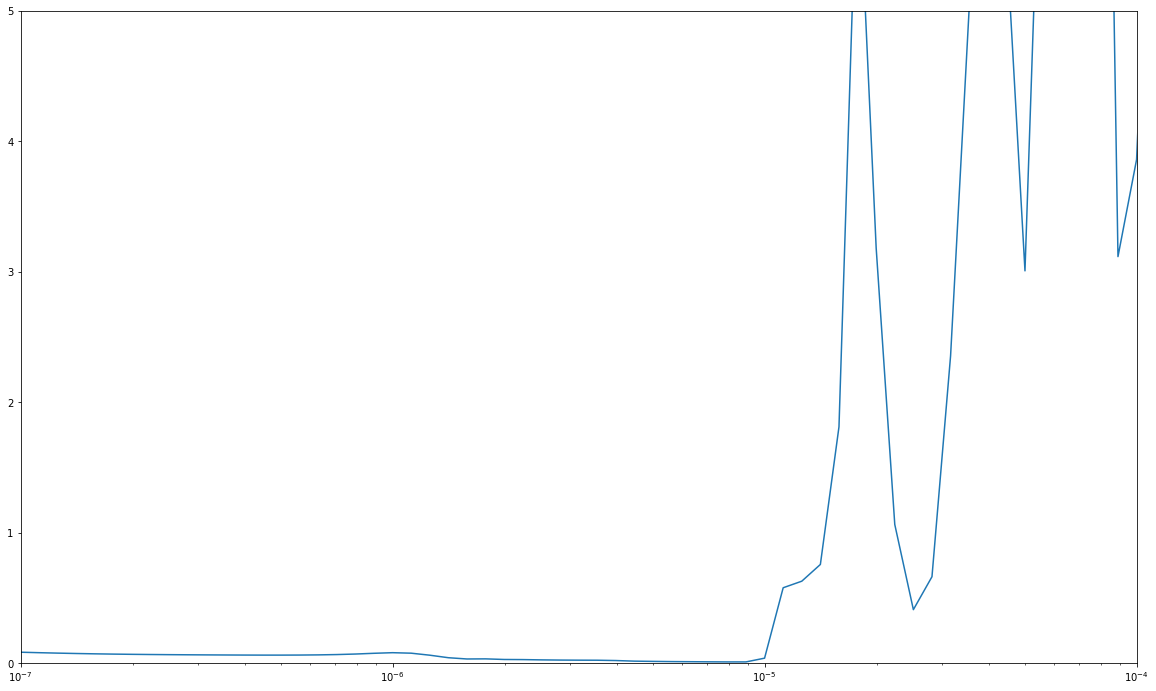

In [96]:
# ONLY RUN THIS CELL ONCE TO VIEW 'learning rate'

plt.figure(figsize=(20, 12))

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([10e-8, 10e-5, 0, 5])
plt.show()

In [109]:
tf.keras.backend.clear_session()

# window_size = 32
# batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=2e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae', 'acc'])
history = model.fit(train_set, epochs=25, validation_data = val_set)

Epoch 1/25
10/10 [==============================] - 8s 768ms/step - loss: 1.2100 - mae: 1.6652 - acc: 0.0000e+00 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/25
10/10 [==============================] - 3s 349ms/step - loss: 0.2066 - mae: 0.5286 - acc: 0.0000e+00 - val_loss: 0.1821 - val_mae: 0.5420 - val_acc: 0.0000e+00
Epoch 3/25
10/10 [==============================] - 3s 349ms/step - loss: 0.1449 - mae: 0.4490 - acc: 0.0000e+00 - val_loss: 0.1237 - val_mae: 0.4251 - val_acc: 0.0000e+00
Epoch 4/25
10/10 [==============================] - 3s 332ms/step - loss: 0.0808 - mae: 0.3355 - acc: 0.0000e+00 - val_loss: 0.1199 - val_mae: 0.4034 - val_acc: 0.0000e+00
Epoch 5/25
10/10 [==============================] - 4s 350ms/step - loss: 0.0542 - mae: 0.2753 - acc: 0.0000e+00 - val_loss: 0.0734 - val_mae: 0.3246 - val_acc: 0.0000e+00
Epoch 6/25
10/10 [==============================] - 3s 336ms/step - loss: 0.0462 - mae: 0.2499 - acc: 0.0000e+00 - val_loss: 0.0844 

In [114]:

model.summary()
def model_forecast_mod(model, series, window_size, batch_size=32):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
#    forecast = model.predict(ds)
#    return forecast
    return ds

f_set = model_forecast_mod(model, x_valid, window_size, batch_size)
a = model.predict(f_set)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [117]:
type(a)
len(a)
a


array([[[0.5936089 ],
        [0.6039301 ],
        [0.62978274],
        ...,
        [1.0452416 ],
        [1.0740067 ],
        [1.0919641 ]],

       [[0.59361064],
        [0.60384655],
        [0.62977827],
        ...,
        [1.0453895 ],
        [1.0645096 ],
        [1.1069355 ]],

       [[0.5936066 ],
        [0.6040438 ],
        [0.6301177 ],
        ...,
        [1.0354797 ],
        [1.0792696 ],
        [1.1217391 ]],

       ...,

       [[0.5936977 ],
        [0.6021226 ],
        [0.6153194 ],
        ...,
        [0.8589491 ],
        [0.883137  ],
        [0.90346915]],

       [[0.5936965 ],
        [0.60213816],
        [0.6154405 ],
        ...,
        [0.86083674],
        [0.8822926 ],
        [0.907962  ]],

       [[0.5936948 ],
        [0.6022027 ],
        [0.6154099 ],
        ...,
        [0.85968477],
        [0.88655037],
        [0.90721303]]], dtype=float32)

In [ ]:
# Write resulting dataframe to COS in parquet format
data_url = cos.url(this_stage + ".parquet", bucket_name)
df_all.write.parquet(data_url)